In [163]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn import model_selection

from numpy import argmax

In [164]:
df = pd.read_csv('/content/drive/MyDrive/Project/dataset/train.csv')

In [194]:
df

,SITE_ID,DATE,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_TRP,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_temperature_prev3d,max_temperature_prev3d,min_temperature_prev3d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,mean_rain_mm_prev3d,max_rain_mm_prev3d,min_rain_mm_prev3d,mean_humidity_prev7d,max_humidity_prev7d,min_humidity_prev7d,mean_humidity_prev3d,max_humidity_prev3d,min_humidity_prev3d,mean_wind_speed_prev7d,...,equipment_max_persistance_prev7d,equipment_mean_persistance_prev7d,equipment_min_persistance_prev7d,fire/smoke_max_persistance_prev7d,fire/smoke_mean_persistance_prev7d,fire/smoke_min_persistance_prev7d,ge_max_persistance_prev7d,ge_mean_persistance_prev7d,ge_min_persistance_prev7d,power_max_persistance_prev7d,power_mean_persistance_prev7d,power_min_persistance_prev7d,temperature_max_persistance_prev7d,temperature_mean_persistance_prev7d,temperature_min_persistance_prev7d,equipment_max_persistance_prev3d,equipment_mean_persistance_prev3d,equipment_min_persistance_prev3d,fire/smoke_max_persistance_prev3d,fire/smoke_mean_persistance_prev3d,fire/smoke_min_persistance_prev3d,ge_max_persistance_prev3d,ge_mean_persistance_prev3d,ge_min_persistance_prev3d,power_max_persistance_prev3d,power_mean_persistance_prev3d,power_min_persistance_prev3d,temperature_max_persistance_prev3d,temperature_mean_persistance_prev3d,temperature_min_persistance_prev3d,skew_equipment_alarms_prev14d,skew_fire/smoke_alarms_prev14d,skew_ge_alarms_prev14d,skew_power_alarms_prev14d,skew_temperature_alarms_prev14d,kurt_equipment_alarms_prev14d,kurt_fire/smoke_alarms_prev14d,kurt_ge_alarms_prev14d,kurt_power_alarms_prev14d,kurt_temperature_alarms_prev14d
0,146,2019-04-10,1,0,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,10.29,14.0,6.0,12.00,14.0,9.0,1.33,8.5,0.0,3.10,8.5,0.3,62.71,81.0,45.0,70.67,81.0,58.0,11.43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308
1,146,2019-04-11,1,0,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,11.71,16.0,9.0,13.00,16.0,9.0,1.90,8.5,0.0,4.27,8.5,0.3,66.43,81.0,51.0,75.00,81.0,71.0,11.57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308
2,146,2019-04-12,1,0,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,11.57,16.0,9.0,13.00,16.0,9.0,4.70,19.6,0.0,7.97,19.6,0.3,71.71,88.0,58.0,77.33,88.0,71.0,11.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308
3,146,2019-04-13,1,0,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,11.29,16.0,8.0,11.00,16.0,8.0,4.77,19.6,0.0,8.03,19.6,0.5,74.29,88.0,58.0,80.33,88.0,71.0,11.43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308
4,146,2019-04-14,1,0,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,10.57,16.0,5.0,7.33,9.0,5.0,5.39,19.6,0.3,8.13,19.6,0.5,77.29,88.0,58.0,86.00,88.0,82.0,10.86,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [201]:
[col for col in df.columns if 'aircon' in col]

['aircon_sum_wo_prev7d', 'aircon_sum_wo_prev14d', 'aircon_sum_target_next14d']

In [200]:
len([col for col in df.columns if '14d' in col])

32

In [188]:
x = []
for site in df['SITE_ID'].unique():
  mis = len(df[df['SITE_ID']==site]['DATE'].unique())
  if mis != 300:
    print(site)
  x.append(x)
  

In [189]:
np.all(x == 300)

False

In [186]:
x[x>300]

TypeError: ignored

In [ ]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(15,25))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
def plot_roc_curve(y, predictions, ax):
    fpr, tpr, thresholds = roc_curve(y, predictions)
    ax.plot([0,1], [0,1], linestyle='--')
    ax.plot(fpr, tpr, marker='.', label='Random forest')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    ax.plot()

def plot_precision_recall_curve(y, predictions, ax):
    precision, recall, thresholds = precision_recall_curve(y, predictions)
    no_skill = len(y[y==1]) / len(y)
    ax.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    ax.plot(recall, precision, marker='.', label='Random forest')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.legend()
    ax.plot()

def cyclical_encoding(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df

In [ ]:
#Prima di eseguire questo script sarebbe opportuno controllare che le date sono ordinate in ordine crescente

weather_names =['_temperature_','_rain_mm_','_humidity_','_wind_speed_','_pressure_']

for name in weather_names:
  df['max'+name+'prev14d']=df['max'+name+'prev7d']
  df['max'+name+'prev7d_shift']=df['max'+name+'prev7d'].shift(7, axis = 0)
  df.loc[df['DATE']>'2019-04-16', 'max'+name+'prev14d'] = df[df['DATE']>'2019-04-16'][['max'+name+'prev7d','max'+name+'prev7d_shift']].max(axis=1)
  df=df.drop(columns=['max'+name+'prev7d_shift'])

  df['min'+name+'prev14d']=df['min'+name+'prev7d']
  df['min'+name+'prev7d_shift']=df['min'+name+'prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', 'min'+name+'prev14d'] = df[df['DATE']>'2019-04-16'][['min'+name+'prev7d','min'+name+'prev7d_shift']].min(axis=1)
  df=df.drop(columns=['min'+name+'prev7d_shift'])

  df['mean'+name+'prev14d']=df['mean'+name+'prev7d']
  df['mean'+name+'prev7d_shift']=df['mean'+name+'prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', 'mean'+name+'prev14d'] = df[df['DATE']>'2019-04-16'][['mean'+name+'prev7d','mean'+name+'prev7d_shift']].mean(axis=1)
  df=df.drop(columns=['mean'+name+'prev7d_shift'])

persistance_names =['equipment','fire/smoke','ge','power','temperature']

for name in persistance_names:
  df[name+'_max_persistance_prev14d']=df[name+'_max_persistance_prev7d']
  df[name+'_max_persistance_prev7d_shift']=df[name+'_max_persistance_prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', name+'_max_persistance_prev14d'] = df[df['DATE']>'2019-04-16'][[name+'_max_persistance_prev7d',name+'_max_persistance_prev7d_shift']].max(axis=1)
  df=df.drop(columns=[name+'_max_persistance_prev7d_shift'])
  
  df[name+'_min_persistance_prev14d']=df[name+'_min_persistance_prev7d']
  df[name+'_min_persistance_prev7d_shift']=df[name+'_min_persistance_prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', name+'_min_persistance_prev14d'] = df[df['DATE']>'2019-04-16'][[name+'_min_persistance_prev7d',name+'_min_persistance_prev7d_shift']].min(axis=1)
  df=df.drop(columns=[name+'_min_persistance_prev7d_shift'])

  df[name+'_mean_persistance_prev14d']=df[name+'_mean_persistance_prev7d']
  df[name+'_mean_persistance_prev7d_shift']=df[name+'_mean_persistance_prev7d'].shift(7, axis = 0)
  df.loc[df.DATE>'2019-04-16', name+'_mean_persistance_prev14d'] = df[df['DATE']>'2019-04-16'][[name+'_mean_persistance_prev7d',name+'_mean_persistance_prev7d_shift']].mean(axis=1)
  df=df.drop(columns=[name+'_mean_persistance_prev7d_shift'])

In [ ]:
#drop unused columns
df = df.drop(columns='CELL_TYPE_TRP')

#process data feature
df['DATE'] = pd.to_datetime(df['DATE'])
df['month'] = df['DATE'].dt.month
df['day'] = df['DATE'].dt.day
df['year'] = df['DATE'].dt.year % 2019
#df = df.drop(columns='DATE')

In [ ]:
df.head(10)

,SITE_ID,DATE,CELL_TYPE_Macro,CELL_TYPE_Mobil,CELL_TYPE_Tx site,CELL_TYPE_micro,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_temperature_prev3d,max_temperature_prev3d,min_temperature_prev3d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,mean_rain_mm_prev3d,max_rain_mm_prev3d,min_rain_mm_prev3d,mean_humidity_prev7d,max_humidity_prev7d,min_humidity_prev7d,mean_humidity_prev3d,max_humidity_prev3d,min_humidity_prev3d,mean_wind_speed_prev7d,max_wind_speed_prev7d,...,skew_temperature_alarms_prev14d,kurt_equipment_alarms_prev14d,kurt_fire/smoke_alarms_prev14d,kurt_ge_alarms_prev14d,kurt_power_alarms_prev14d,kurt_temperature_alarms_prev14d,max_temperature_prev14d,min_temperature_prev14d,mean_temperature_prev14d,max_rain_mm_prev14d,min_rain_mm_prev14d,mean_rain_mm_prev14d,max_humidity_prev14d,min_humidity_prev14d,mean_humidity_prev14d,max_wind_speed_prev14d,min_wind_speed_prev14d,mean_wind_speed_prev14d,max_pressure_prev14d,min_pressure_prev14d,mean_pressure_prev14d,equipment_max_persistance_prev14d,equipment_min_persistance_prev14d,equipment_mean_persistance_prev14d,fire/smoke_max_persistance_prev14d,fire/smoke_min_persistance_prev14d,fire/smoke_mean_persistance_prev14d,ge_max_persistance_prev14d,ge_min_persistance_prev14d,ge_mean_persistance_prev14d,power_max_persistance_prev14d,power_min_persistance_prev14d,power_mean_persistance_prev14d,temperature_max_persistance_prev14d,temperature_min_persistance_prev14d,temperature_mean_persistance_prev14d,month,day,year,equipment_sum_alarms_prev7d_day
0,146,2019-04-10,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,10.29,14.0,6.0,12.00,14.0,9.0,1.33,8.5,0.0,3.10,8.5,0.3,62.71,81.0,45.0,70.67,81.0,58.0,11.43,16.0,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,14.0,6.0,10.290,8.5,0.0,1.330,81.0,45.0,62.710,16.0,5.0,11.430,1022.0,1006.0,1013.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,10,0,0.0
1,146,2019-04-11,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,11.71,16.0,9.0,13.00,16.0,9.0,1.90,8.5,0.0,4.27,8.5,0.3,66.43,81.0,51.0,75.00,81.0,71.0,11.57,16.0,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,9.0,11.710,8.5,0.0,1.900,81.0,51.0,66.430,16.0,5.0,11.570,1017.0,1006.0,1010.860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,11,0,0.0
2,146,2019-04-12,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,11.57,16.0,9.0,13.00,16.0,9.0,4.70,19.6,0.0,7.97,19.6,0.3,71.71,88.0,58.0,77.33,88.0,71.0,11.71,16.0,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,9.0,11.570,19.6,0.0,4.700,88.0,58.0,71.710,16.0,5.0,11.710,1015.0,1006.0,1009.710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,12,0,0.0
3,146,2019-04-13,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,11.29,16.0,8.0,11.00,16.0,8.0,4.77,19.6,0.0,8.03,19.6,0.5,74.29,88.0,58.0,80.33,88.0,71.0,11.43,16.0,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,8.0,11.290,19.6,0.0,4.770,88.0,58.0,74.290,16.0,5.0,11.430,1013.0,1006.0,1009.430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,13,0,0.0
4,146,2019-04-14,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,10.57,16.0,5.0,7.33,9.0,5.0,5.39,19.6,0.3,8.13,19.6,0.5,77.29,88.0,58.0,86.00,88.0,82.0,10.86,15.0,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,5.0,10.570,19.6,0.3,5.390,88.0,58.0,77.290,15.0,5.0,10.860,1016.0,1006.0,1009.860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,14,0,0.0
5,146,2019-04-15,1,0,0,0,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0.0,0,9.43,16.0,5.0,6.00,8.0,5.0,5.80,19.6,0.3,2.73,4.3,0.5,80.71,88.0,71.0,84.00,88.0,82.0,11.29,15.0,...,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0,5.0,9.430,19.6,0.3,5.800,88.0,71.0,80.7

In [ ]:
df.columns

Index(['SITE_ID', 'DATE', 'CELL_TYPE_Macro', 'CELL_TYPE_Mobil',
       'CELL_TYPE_Tx site', 'CELL_TYPE_micro', 'N_TRANSPORTED_SITES',
       'GEOGRAPHIC_CLUSTER_K_0', 'GEOGRAPHIC_CLUSTER_K_1',
       'GEOGRAPHIC_CLUSTER_K_2',
       ...
       'ge_mean_persistance_prev14d', 'power_max_persistance_prev14d',
       'power_min_persistance_prev14d', 'power_mean_persistance_prev14d',
       'temperature_max_persistance_prev14d',
       'temperature_min_persistance_prev14d',
       'temperature_mean_persistance_prev14d', 'month', 'day', 'year'],
      dtype='object', length=168)

In [ ]:
len(df['SITE_ID'].unique())

2071

#Each day

In [ ]:
I = np.identity(300);
v_zero = np.zeros((300, 1))

#7d

In [ ]:
a= np.concatenate((I,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
I1=np.concatenate((a,v_zero),axis=1)
I1

a= np.concatenate((v_zero,I),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
I2=np.concatenate((a,v_zero),axis=1)
I2

a= np.concatenate((v_zero,I),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
I3=np.concatenate((a,v_zero),axis=1)
I3

a= np.concatenate((v_zero,I),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
I4=np.concatenate((a,v_zero),axis=1)
I4

a= np.concatenate((v_zero,I),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((a,v_zero),axis=1)
I5=np.concatenate((a,v_zero),axis=1)
I5

a= np.concatenate((v_zero,I),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
I6=np.concatenate((a,v_zero),axis=1)
I6

a= np.concatenate((v_zero,I),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
I7=np.concatenate((v_zero,a),axis=1)
I7

I_7d = np.add(I1, I2)
I_7d = np.add(I_7d, I3)
I_7d = np.add(I_7d, I4)
I_7d = np.add(I_7d, I5)
I_7d = np.add(I_7d, I6)
I_7d = np.add(I_7d, I7)

In [ ]:
I_7d_square = I_7d[:,6:306]

In [ ]:
#from scipy.linalg import block_diag
#I_7d_all = I_7d_square;
#for i in range(1, 2071):
#  I_7d_all = block_diag(I_7d_all, I_7d_square)
#  print(i)
#
#I_7d_all.shape()

In [ ]:
b = df[['equipment_sum_alarms_prev7d']]

In [ ]:
x = []
for site in df['SITE_ID'].unique():
  b_site = df[df['SITE_ID']==site]['equipment_sum_alarms_prev7d']
  x_site = np.linalg.solve(I_7d_square, b_site)

  x = np.concatenate((x, x_site), axis=0)


In [ ]:
df['equipment_sum_alarms_prev7d_day'] = pd.Series(x, index=df.index)

In [ ]:
#df[['equipment_sum_alarms_prev7d_day','equipment_sum_alarms_prev7d']].to_csv(path_or_buf='/content/drive/MyDrive/Project/dataset/day.csv',  index=False)

#14d

In [ ]:
a= np.concatenate((I,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
I14_1=np.concatenate((a,v_zero),axis=1)
I14_1

a= np.concatenate((v_zero,I),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
I14_2=np.concatenate((a,v_zero),axis=1)
I14_2

a= np.concatenate((v_zero,I),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
I14_3=np.concatenate((a,v_zero),axis=1)
I14_3

a= np.concatenate((v_zero,I),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
I14_4=np.concatenate((a,v_zero),axis=1)
I14_4

a= np.concatenate((v_zero,I),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
I14_5=np.concatenate((a,v_zero),axis=1)
I14_5

a= np.concatenate((v_zero,I),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
I14_6=np.concatenate((a,v_zero),axis=1)
I14_6

a= np.concatenate((v_zero,I),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
I14_7=np.concatenate((a,v_zero),axis=1)
I14_7

a= np.concatenate((v_zero,I),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
I14_8=np.concatenate((a,v_zero),axis=1)
I14_8

a= np.concatenate((v_zero,I),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
I14_9=np.concatenate((a,v_zero),axis=1)
I14_9

a= np.concatenate((v_zero,I),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
I14_10=np.concatenate((a,v_zero),axis=1)
I14_10

a= np.concatenate((v_zero,I),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((a,v_zero),axis=1)
a= np.concatenate((a,v_zero),axis=1)
I14_11=np.concatenate((a,v_zero),axis=1)
I14_11

a= np.concatenate((v_zero,I),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((a,v_zero),axis=1)
I14_12=np.concatenate((a,v_zero),axis=1)
I14_12

a= np.concatenate((v_zero,I),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
I14_13=np.concatenate((a,v_zero),axis=1)
I14_13

a= np.concatenate((v_zero,I),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
a= np.concatenate((v_zero,a),axis=1)
I14_14= np.concatenate((v_zero,a),axis=1)
I14_14

I_14d = np.add(I14_1, I14_2)
I_14d = np.add(I_14d, I14_3)
I_14d = np.add(I_14d, I14_4)
I_14d = np.add(I_14d, I14_5)
I_14d = np.add(I_14d, I14_6)
I_14d = np.add(I_14d, I14_7)
I_14d = np.add(I_14d, I14_8)
I_14d = np.add(I_14d, I14_9)
I_14d = np.add(I_14d, I14_10)
I_14d = np.add(I_14d, I14_11)
I_14d = np.add(I_14d, I14_12)
I_14d = np.add(I_14d, I14_13)
I_14d = np.add(I_14d, I14_14)
I_14d

I_14d_square_prev = I_14d[:,13:313]
I_14d_square_next = I_14d[:,0:300]/14

In [ ]:
df_day = df[['SITE_ID']]

features_prev = ['equipment_sum_alarms_prev14d','fire/smoke_sum_alarms_prev14d','ge_sum_alarms_prev14d','power_sum_alarms_prev14d',
                 'temperature_sum_alarms_prev14d','skew_equipment_alarms_prev14d','skew_fire/smoke_alarms_prev14d','skew_ge_alarms_prev14d',
                 'skew_power_alarms_prev14d','skew_temperature_alarms_prev14d','kurt_equipment_alarms_prev14d','kurt_fire/smoke_alarms_prev14d',
                 'kurt_ge_alarms_prev14d','kurt_power_alarms_prev14d','kurt_temperature_alarms_prev14d']
features_next = ['mean_temperature_f_next14d','mean_rain_mm_f_next14d','mean_humidity_f_next14d','mean_wind_speed_f_next14d','mean_pressure_f_next14d']

In [ ]:
for feature_p in features_prev:
  print(feature_p)
  x = []
  for site in df['SITE_ID'].unique():
    b_site = df[df['SITE_ID']==site][feature_p]
    x_site = np.linalg.solve(I_14d_square_prev, b_site)
    x = np.concatenate((x, x_site), axis=0)
  
  df_day[feature_p+'_day'] = pd.Series(x, index=df_day.index)

for feature_n in features_next:
  print(feature_n)
  x = []
  for site in df['SITE_ID'].unique():
    b_site = df[df['SITE_ID']==site][feature_n]
    x_site = np.linalg.solve(I_14d_square_next, b_site)
    x = np.concatenate((x, x_site), axis=0)
  
  df_day[feature_n+'_day'] = pd.Series(x, index=df_day.index)

equipment_sum_alarms_prev14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


fire/smoke_sum_alarms_prev14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


ge_sum_alarms_prev14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


power_sum_alarms_prev14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


temperature_sum_alarms_prev14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


skew_equipment_alarms_prev14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


skew_fire/smoke_alarms_prev14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


skew_ge_alarms_prev14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


skew_power_alarms_prev14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


skew_temperature_alarms_prev14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


kurt_equipment_alarms_prev14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


kurt_fire/smoke_alarms_prev14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


kurt_ge_alarms_prev14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


kurt_power_alarms_prev14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


kurt_temperature_alarms_prev14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


mean_temperature_f_next14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


mean_rain_mm_f_next14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


mean_humidity_f_next14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


mean_wind_speed_f_next14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


mean_pressure_f_next14d


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_day['aircon_sum_target_next14d']= df['aircon_sum_target_next14d']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_day.head()

,SITE_ID,equipment_sum_alarms_prev14d_day,fire/smoke_sum_alarms_prev14d_day,ge_sum_alarms_prev14d_day,power_sum_alarms_prev14d_day,temperature_sum_alarms_prev14d_day,skew_equipment_alarms_prev14d_day,skew_fire/smoke_alarms_prev14d_day,skew_ge_alarms_prev14d_day,skew_power_alarms_prev14d_day,skew_temperature_alarms_prev14d_day,kurt_equipment_alarms_prev14d_day,kurt_fire/smoke_alarms_prev14d_day,kurt_ge_alarms_prev14d_day,kurt_power_alarms_prev14d_day,kurt_temperature_alarms_prev14d_day,mean_temperature_f_next14d_day,mean_rain_mm_f_next14d_day,mean_humidity_f_next14d_day,mean_wind_speed_f_next14d_day,mean_pressure_f_next14d_day,aircon_sum_target_next14d
0,146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,6.16,19.60,27.72,2.10,-11.90,0
1,146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.76,0.42,22.68,7.28,-5.18,0
2,146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.96,3.50,4.06,4.20,-12.18,0
3,146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.28,3.36,6.72,7.00,-13.44,0
4,146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-2.80,-0.14,13.02,9.52,-3.78,0


In [ ]:
df_day['aircon_sum_target_next14d_day'] = 0

for ind in range(0,df_day.shape[0]):
  
  val = df['aircon_sum_target_next14d'].loc[ind]
  site = df['SITE_ID'].loc[ind]

  if val>0:
    for i in range(0,14):
      if df['SITE_ID'].loc[ind]==df['SITE_ID'].loc[ind+i]:
        df_day['aircon_sum_target_next14d_day'].loc[ind+i]+=1/14

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

#Model

In [ ]:
import random

arr_site_id = df_day['SITE_ID'].unique()
random.shuffle(arr_site_id)

site_train = arr_site_id[:1656]
site_test = arr_site_id[-(len(arr_site_id)-1656):]

df_train = df_day.loc[df_day['SITE_ID'].isin(site_train)]
df_test = df_day.loc[df_day['SITE_ID'].isin(site_test)]

df_train = df_train.drop(columns='SITE_ID')
df_test = df_test.drop(columns='SITE_ID')

df_train=df_train.sample(frac = 1) 
df_test=df_test.sample(frac = 1) 

X_train=df_train.drop(columns=['aircon_sum_target_next14d','aircon_sum_target_next14d_day'])
y_train=df_train['aircon_sum_target_next14d_day']
X_test=df_test.drop(columns=['aircon_sum_target_next14d','aircon_sum_target_next14d_day'])
y_test=df_test['aircon_sum_target_next14d']

In [ ]:
clf_RandomForest = RandomForestRegressor(n_estimators = 20, random_state=0)
clf_RandomForest.fit(X_train, y_train)
y_pred = clf_RandomForest.predict(X_test)

In [ ]:
np.sort(y_pred)

array([0.        , 0.        , 0.        , ..., 0.65      , 0.72142857,
       0.76428571])

In [ ]:
for th in np.arange(0, 1, 0.05):
  y_pred_t=np.zeros(len(y_pred))
  y_pred_t[y_pred>th]=1
  f1 = metrics.f1_score(y_test, y_pred_t)
  print('F1 score ' + str(f1) + ' with threshold ' + str(th) )

F1 score 0.020326733418655426 with threshold 0.0
F1 score 0.02065970184293931 with threshold 0.05
F1 score 0.02198980960042907 with threshold 0.1
F1 score 0.021698113207547172 with threshold 0.15000000000000002
F1 score 0.015288394718554553 with threshold 0.2
F1 score 0.009132420091324202 with threshold 0.25
F1 score 0.004347826086956522 with threshold 0.30000000000000004
F1 score 0.004784688995215312 with threshold 0.35000000000000003
F1 score 0.0 with threshold 0.4
F1 score 0.0 with threshold 0.45
F1 score 0.0 with threshold 0.5
F1 score 0.0 with threshold 0.55
F1 score 0.0 with threshold 0.6000000000000001
F1 score 0.0 with threshold 0.65
F1 score 0.0 with threshold 0.7000000000000001
F1 score 0.0 with threshold 0.75
F1 score 0.0 with threshold 0.8
F1 score 0.0 with threshold 0.8500000000000001
F1 score 0.0 with threshold 0.9
F1 score 0.0 with threshold 0.9500000000000001


In [ ]:
y_pred_thre=np.zeros(len(y_pred))
y_pred_thre[y_pred>0.2]=1

y_pred_thre

array([0., 0., 0., ..., 0., 0., 0.])

Accuracy:  0.9893734939759036
Precision:  0.04447852760736196
Recall:  0.039780521262002745
F1-score:  0.041998551774076756


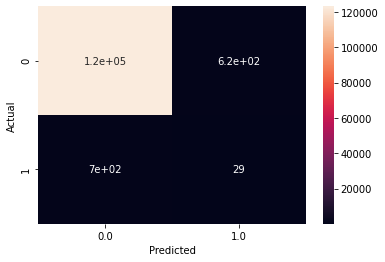

In [ ]:
confusion_matrix = pd.crosstab(y_test, y_pred_thre, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_thre))
print('Precision: ',metrics.precision_score(y_test, y_pred_thre))
print('Recall: ',metrics.recall_score(y_test, y_pred_thre))
print('F1-score: ',metrics.f1_score(y_test, y_pred_thre))

plt.show()

#Cluster

In [ ]:
df_14d_plus = df[[col for col in df.columns if '3d' not in col and '7d' not in col and 'CELL_TYPE_' not in col 
                  and 'year' not in col and 'DATE' not in col]]
df_14d_plus.head()

,SITE_ID,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER_K_0,GEOGRAPHIC_CLUSTER_K_1,GEOGRAPHIC_CLUSTER_K_2,GEOGRAPHIC_CLUSTER_K_3,GEOGRAPHIC_CLUSTER_K_4,GEOGRAPHIC_CLUSTER_K_5,GEOGRAPHIC_CLUSTER_K_6,GEOGRAPHIC_CLUSTER_K_7,GEOGRAPHIC_CLUSTER_K_8,GEOGRAPHIC_CLUSTER_K_9,aircon_sum_wo_prev14d,aircon_sum_target_next14d,mean_temperature_f_next14d,max_temperature_f_next14d,min_temperature_f_next14d,mean_rain_mm_f_next14d,max_rain_mm_f_next14d,min_rain_mm_f_next14d,mean_humidity_f_next14d,max_humidity_f_next14d,min_humidity_f_next14d,mean_wind_speed_f_next14d,max_wind_speed_f_next14d,min_wind_speed_f_next14d,mean_pressure_f_next14d,max_pressure_f_next14d,min_pressure_f_next14d,equipment_sum_alarms_prev14d,fire/smoke_sum_alarms_prev14d,ge_sum_alarms_prev14d,power_sum_alarms_prev14d,temperature_sum_alarms_prev14d,skew_equipment_alarms_prev14d,skew_fire/smoke_alarms_prev14d,skew_ge_alarms_prev14d,skew_power_alarms_prev14d,skew_temperature_alarms_prev14d,kurt_equipment_alarms_prev14d,kurt_fire/smoke_alarms_prev14d,kurt_ge_alarms_prev14d,kurt_power_alarms_prev14d,kurt_temperature_alarms_prev14d,max_temperature_prev14d
0,146,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,8.00,12.0,5.0,4.79,19.6,0.1,74.29,89.0,58.0,12.86,17.0,5.0,1020.71,1028.0,1009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,14.0
1,146,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,8.50,16.0,5.0,3.52,12.5,0.1,72.93,89.0,58.0,12.57,17.0,5.0,1021.71,1028.0,1013.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0
2,146,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,9.36,20.0,5.0,3.63,12.5,0.1,72.00,89.0,58.0,12.29,17.0,5.0,1022.14,1028.0,1016.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0
3,146,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,10.57,22.0,5.0,3.40,12.5,0.1,70.07,89.0,58.0,12.14,17.0,5.0,1021.86,1028.0,1012.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0
4,146,3.0,0,0,0,0,0,0,0,0,1,0,0.0,0,11.50,22.0,5.0,3.49,12.5,0.1,69.07,89.0,58.0,11.64,17.0,5.0,1021.29,1028.0,1009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,16.0


In [ ]:
myDict_ft = {}
myDict_ft["precision"] = [] 
myDict_ft["recall"] = [] 
myDict_ft["F1"] = [] 
myDict_ft["fault"] = [] 

import random

arr_site_id = df_14d_plus['SITE_ID'].unique()
random.shuffle(arr_site_id)

site_train = arr_site_id[:1656]
site_test = arr_site_id[-(len(arr_site_id)-1656):]


for i in range(10):
  name='GEOGRAPHIC_CLUSTER_K_'+str(i);

  df_cluster = df_14d_plus[df_14d_plus[name]>0]

  df_train = df_cluster.loc[df_cluster['SITE_ID'].isin(site_train)]
  df_test = df_cluster.loc[df_cluster['SITE_ID'].isin(site_test)]

  df_train = df_train.drop(columns='SITE_ID')
  df_test = df_test.drop(columns='SITE_ID')

  df_train=df_train.sample(frac = 1) 
  df_test=df_test.sample(frac = 1) 

  X_train=df_train.drop(columns=['aircon_sum_target_next14d'])
  y_train=df_train['aircon_sum_target_next14d']
  X_test=df_test.drop(columns=['aircon_sum_target_next14d'])
  y_test=df_test['aircon_sum_target_next14d']

  clf_RandomForest = RandomForestClassifier(n_estimators = 20, random_state=0)
  clf_RandomForest.fit(X_train, y_train)
  y_pred_c = clf_RandomForest.predict(X_test)

  myDict_ft['precision'].append(metrics.precision_score(y_test, y_pred_c))
  myDict_ft['recall'].append(metrics.recall_score(y_test, y_pred_c))
  myDict_ft["F1"].append(metrics.f1_score(y_test, y_pred_c))
  myDict_ft["fault"].append(y_train[y_train>0].count())

myDict_ft

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'F1': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0202020202020202],
 'fault': [196, 143, 343, 460, 178, 112, 252, 368, 112, 613],
 'precision': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.037037037037037035],
 'recall': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.013888888888888888]}

In [ ]:
df['sum-cell']= df[['CELL_TYPE_Macro','CELL_TYPE_Mobil',	'CELL_TYPE_Tx site',	'CELL_TYPE_micro']].sum(axis = 1)
df[df['sum-cell']==0][['SITE_ID','sum-cell']]

,SITE_ID,sum-cell
82200,2399,0
82201,2399,0
82202,2399,0
82203,2399,0
82204,2399,0
...,...,...
617095,2377,0
617096,2377,0
617097,2377,0
617098,2377,0


In [ ]:
df[df['sum-cell']==0]['SITE_ID'].unique()

array([2399, 1673, 1509,    7, 1415, 1175,   75, 1816,  903, 1632, 1224,
       1737, 1775, 1215, 2377])

In [ ]:
df['sum_cell']= df[['CELL_TYPE_Macro','CELL_TYPE_Mobil',	'CELL_TYPE_Tx site',	'CELL_TYPE_micro', 'CELL_TYPE_TRP']].sum(axis = 1)
df[df['sum_cell']==0][['SITE_ID','sum_cell']]

0         1
1         1
2         1
3         1
4         1
         ..
621295    1
621296    1
621297    1
621298    1
621299    1
Name: sum-cell, Length: 621300, dtype: int64

In [ ]:
df['sum_cell_gc']= df[['GEOGRAPHIC_CLUSTER_K_0','GEOGRAPHIC_CLUSTER_K_1','GEOGRAPHIC_CLUSTER_K_2','GEOGRAPHIC_CLUSTER_K_3','GEOGRAPHIC_CLUSTER_K_4',
                       'GEOGRAPHIC_CLUSTER_K_5','GEOGRAPHIC_CLUSTER_K_6','GEOGRAPHIC_CLUSTER_K_7','GEOGRAPHIC_CLUSTER_K_8','GEOGRAPHIC_CLUSTER_K_9']].sum(axis = 1)
df[df['sum_cell_gc']==0][['SITE_ID','sum_cell_gc']]

,SITE_ID,sum_cell_gc


In [ ]:
df['sum_cell_gc']

0         1
1         1
2         1
3         1
4         1
         ..
621295    1
621296    1
621297    1
621298    1
621299    1
Name: sum_cell_gc, Length: 621300, dtype: int64